In [ ]:
import os
import numpy as np
from collections import Counter
import torch
import torchvision.transforms.functional as TF
from torchvision import transforms
from scipy.ndimage import distance_transform_edt
from skimage import segmentation, morphology
from PIL import Image
from tqdm import tqdm
from pathlib import Path
import yaml
import matplotlib.pyplot as plt
import nbimporter
import visualization

In [ ]:
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

DATA_DIR = Path(config["paths"]["DATA_DIR"])
OUTPUT_DIR = Path(config["paths"]["OUTPUT_DIR"])
WEIGHTS_DIR = Path(config["paths"]["WEIGHTS_DIR"])

In [ ]:
import numpy as np
from scipy.ndimage import distance_transform_edt, binary_erosion
from skimage.segmentation import find_boundaries

def compute_weight_map_multiclass(mask: np.ndarray, num_classes: int, w0=10, sigma=5) -> np.ndarray:
    """
    Computes U-Net weight map for multi-class segmentation.

    Parameters:
        mask: (H, W) np.ndarray with class labels (0 to num_classes - 1)
        num_classes: Total number of semantic classes
        w0: Border weight coefficient
        sigma: Controls border decay

    Returns:
        weight_map: (H, W) np.ndarray
    """

    H, W = mask.shape

    # Step 1: Class balancing weight wc(x)
    wc = np.zeros_like(mask, dtype=np.float32)
    class_weights = {}
    total_pixels = H * W

    for cls in range(num_classes):
        cls_mask = (mask == cls)
        count = np.sum(cls_mask)
        if count > 0:
            class_weights[cls] = total_pixels / count
            wc[cls_mask] = class_weights[cls]
        else:
            class_weights[cls] = 0

    # Step 2: Border term (distance to class boundaries)
    # Find boundaries between semantic regions
    boundaries = find_boundaries(mask, mode='thick').astype(np.uint8)

    # Invert boundaries to get non-boundary regions for distance transform
    non_boundary = 1 - boundaries

    # Compute distance to nearest boundary for all pixels
    dist_to_boundary = distance_transform_edt(non_boundary)

    # Simulate (d1 + d2) using distance to boundary from both sides
    border_term = w0 * np.exp(- (dist_to_boundary ** 2) / (2 * sigma ** 2))

    # Final weight map
    weight_map = wc + border_term
    return weight_map


In [ ]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

def generate_and_save_weight_maps(
    mask_dir: str,
    save_dir: str,
    num_classes: int,
    w0: float = 10,
    sigma: float = 5,
    file_ext: str = ".png"
):
    """
    Generate and save U-Net weight maps for all mask images in a directory.

    Args:
        mask_dir (str): Directory containing segmentation masks (H, W), labels in [0, num_classes-1].
        save_dir (str): Directory to save weight maps as .npy files.
        num_classes (int): Number of semantic classes.
        w0 (float): Border weight strength.
        sigma (float): Border fall-off (Gaussian scale).
        file_ext (str): File extension to filter mask files (e.g., '.png').

    Saves:
        A .npy file for each weight map with the same basename as the mask file.
    """
    os.makedirs(save_dir, exist_ok=True)
    mask_files = [f for f in os.listdir(mask_dir) if f.endswith(file_ext)]

    for fname in tqdm(mask_files, desc="Generating weight maps"):
        mask_path = os.path.join(mask_dir, fname)
        mask = np.array(Image.open(mask_path))

        weight_map = compute_weight_map_multiclass(mask, num_classes=num_classes, w0=w0, sigma=sigma)

        base_name = os.path.splitext(fname)[0]
        save_path = os.path.join(save_dir, base_name + ".npy")
        np.save(save_path, weight_map)


In [ ]:
generate_and_save_weight_maps(
    mask_dir=os.path.join(DATA_DIR, "SegmentationClass"),
    save_dir=WEIGHTS_DIR,
    num_classes=21,
    w0=10,
    sigma=5
)

Generating weight maps: 100%|██████████| 2913/2913 [01:04<00:00, 45.19it/s]


In [ ]:
import numpy as np
from pathlib import Path
from typing import Union

def load_weight_map(weight_dir: Union[str, Path], image_name: str) -> np.ndarray:
    """
    Load a saved weight map (.npy) corresponding to a given mask image name.

    Args:
        weight_dir (str or Path): Directory where .npy weight maps are stored.
        image_name (str): Original image or mask filename (e.g., "2007_000123.png").

    Returns:
        np.ndarray: Loaded weight map (H, W)
    """
    weight_dir = Path(weight_dir)
    base_name = Path(image_name).stem
    weight_path = weight_dir / f"{base_name}.npy"

    if not weight_path.exists():
        raise FileNotFoundError(f"Weight map not found: {weight_path}")

    return np.load(weight_path)

def load_weight_map(weight_dir: Union[str, Path]) -> np.ndarray:
    """
    Load a saved weight map (.npy) corresponding to a given mask image name.

    Args:
        weight_dir (str or Path): Path to where the mask is stored.

    Returns:
        np.ndarray: Loaded weight map (H, W)
    """
    weight_path = Path(weight_dir)
    if not weight_path.exists():
        raise FileNotFoundError(f"Weight map not found: {weight_path}")
    return np.load(weight_path)


(375, 500)


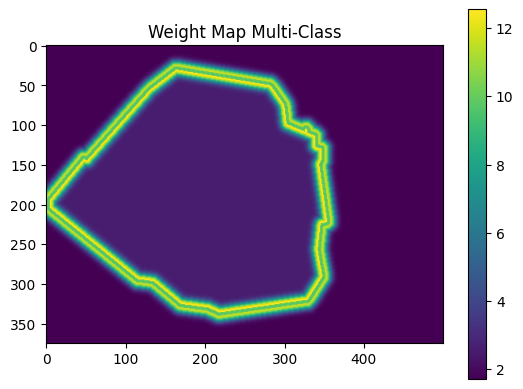

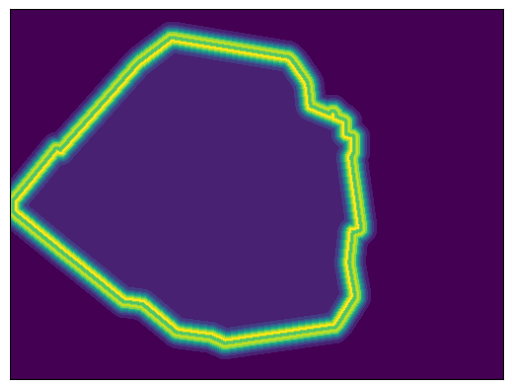

In [ ]:
weight_map = load_weight_map(
    weight_dir=WEIGHTS_DIR,
    image_name="2007_000123.png"
)

print(weight_map.shape)

plt.imshow(weight_map, cmap='viridis')
plt.colorbar()
plt.title("Weight Map Multi-Class")
plt.show()
visualization.show(torch.from_numpy(weight_map).to(torch.uint8))

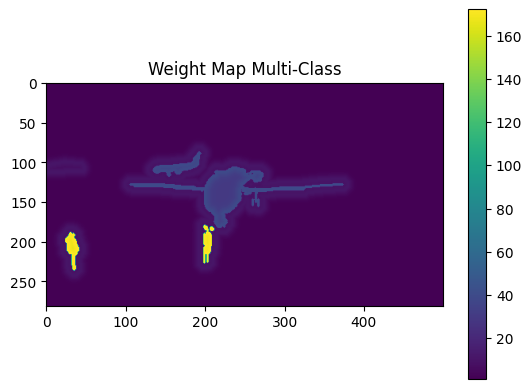

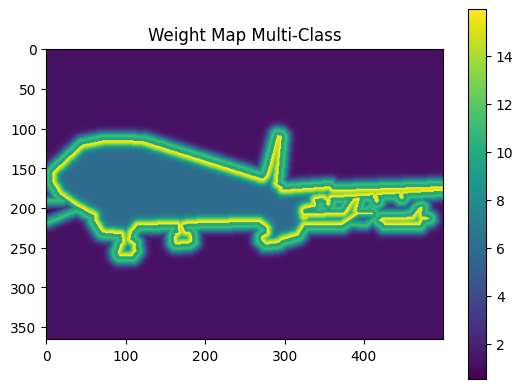

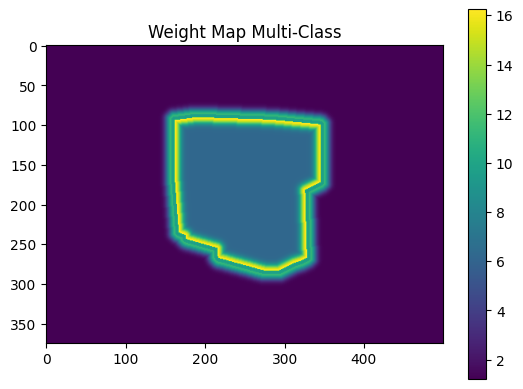

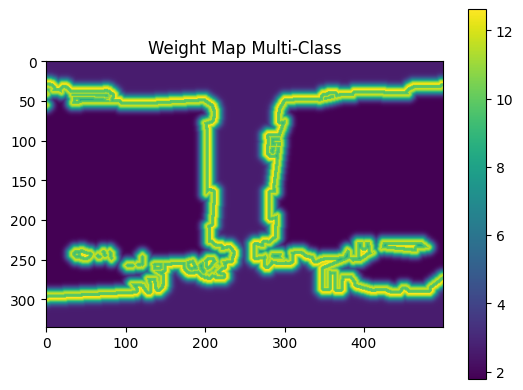

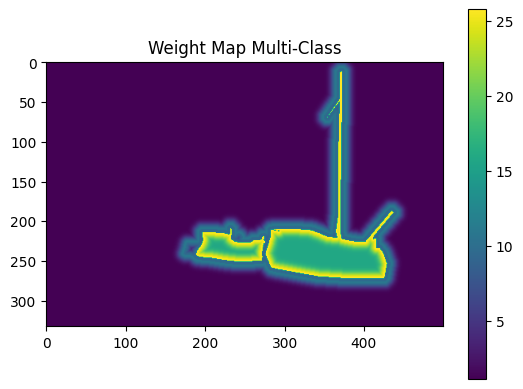

In [ ]:
weight_map_files = os.listdir(Path(r"C:\Users\Hayden\Machine Learning\d2l\d2l-en\pytorch\chapter_computer-vision\data\VOCdevkit\VOC2012\SegmentationWeights"))
for weight_map_file in weight_map_files[:5]:
    weight_map = load_weight_map(
        weight_dir=Path(r"C:\Users\Hayden\Machine Learning\d2l\d2l-en\pytorch\chapter_computer-vision\data\VOCdevkit\VOC2012\SegmentationWeights"),
        image_name=weight_map_file
    )
    plt.imshow(weight_map, cmap='viridis')
    plt.colorbar()
    plt.title("Weight Map Multi-Class")
    plt.show()
